(1517, 2653, 3)


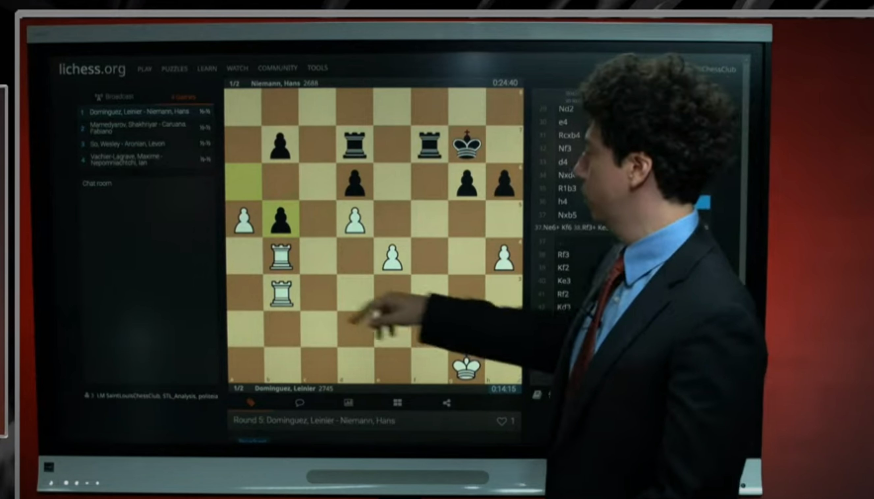

In [104]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('./test3.jpg')
print(img.shape)
# img = cv2.resize(img, (500, 500), interpolation=cv2.INTER_AREA)
scale_percent = 500/img.shape[0]
img = cv2.resize(img, (int(img.shape[1] * scale_percent), int(img.shape[0] * scale_percent)))
cv2_imshow(img)
W = img.shape[0]
H = img.shape[1]


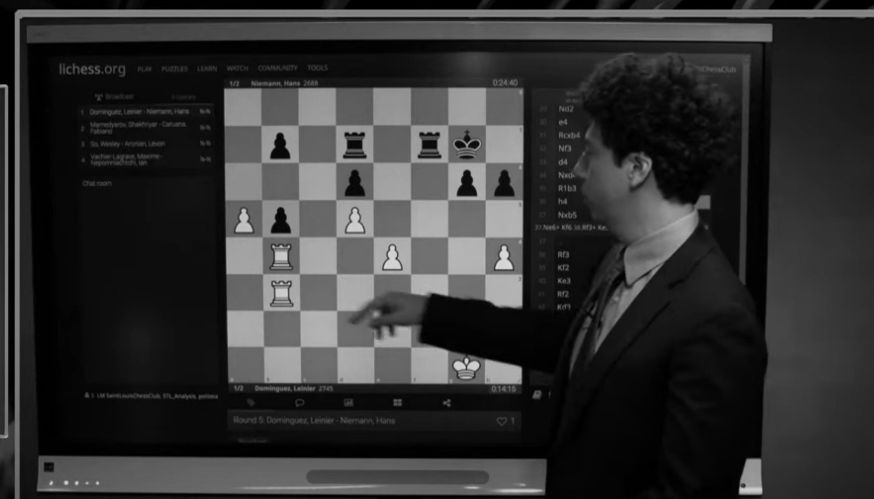

In [105]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_gray)


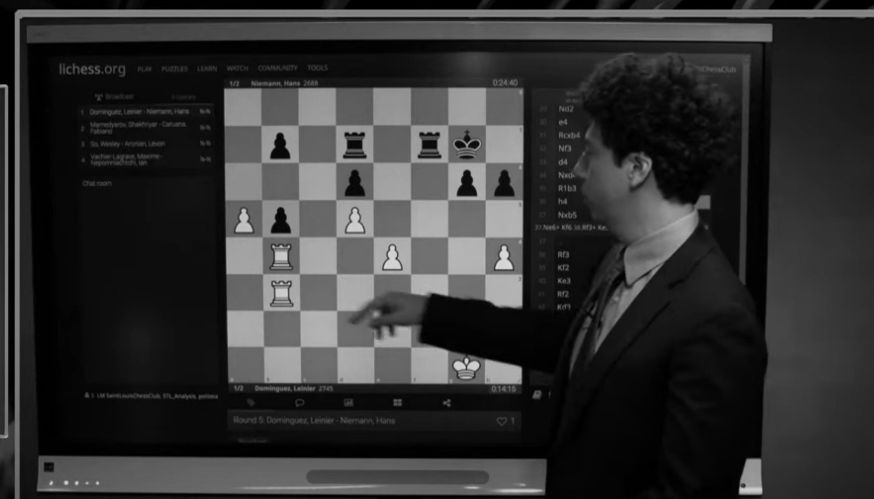

In [106]:
blur_gray = cv2.GaussianBlur(img_gray,(1, 1),0)
cv2_imshow(blur_gray)

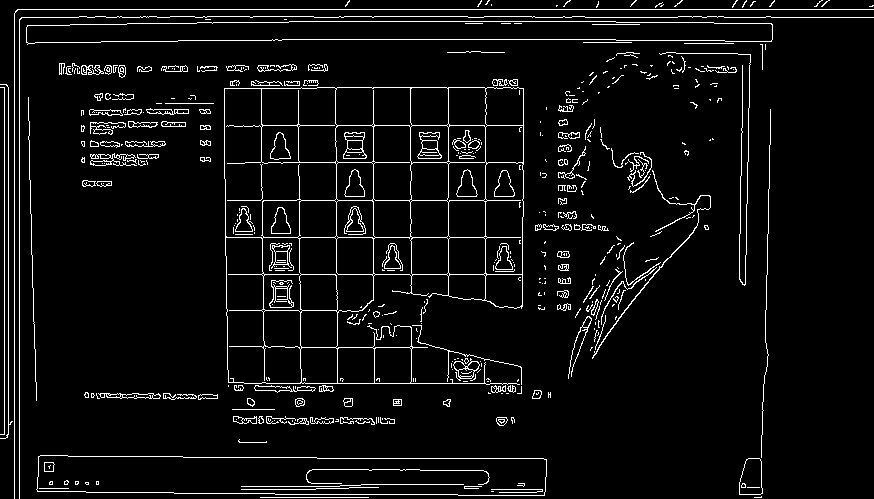

In [107]:
low_threshold = 70
high_threshold = 80
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
cv2_imshow(edges)

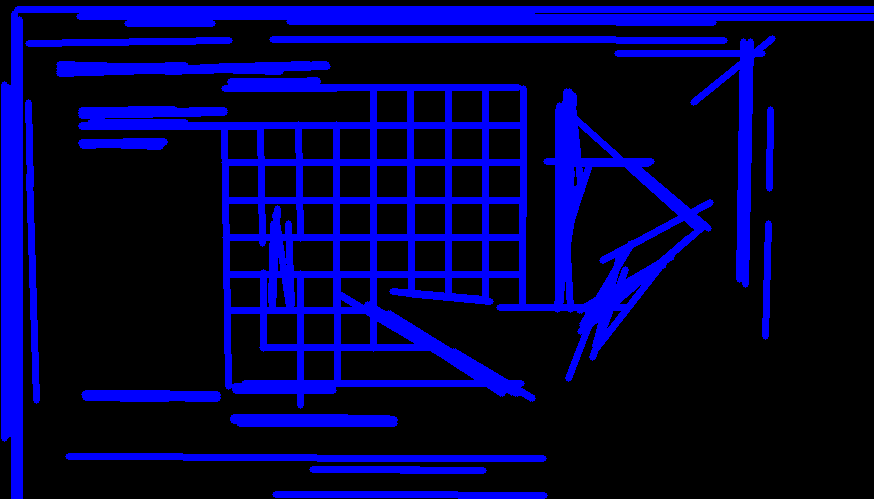

In [108]:
import numpy as np

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 75  # minimum number of pixels making up a line
max_line_gap = 25  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

line_id = [None] * len(lines)
for i,line in enumerate(lines):
  # print(line)
  line_id[i] = line[0]
  if len(line) > 0:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

# lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
cv2_imshow(line_image)

In [109]:
len(line_id)

128

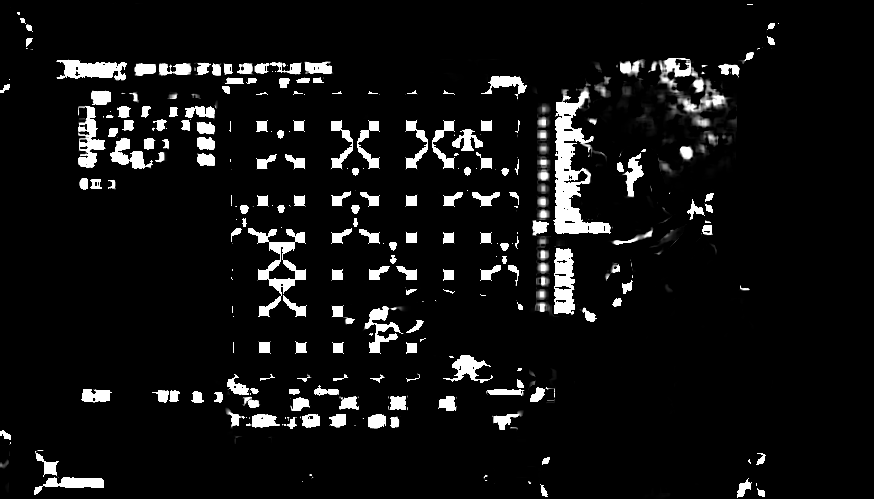

In [110]:
gray = np.float32(img_gray)
dst = cv2.cornerHarris(gray, 10,1, 0.2)

cv2_imshow(dst)

In [111]:
parent = [-1 ]* len(line_id)
size =  [-1 ]* len(line_id)
def make_set(v):
  parent[v] = v
  size[v] = 1

def find_set(v):
  if(v == parent[v]):
    return v
  parent[v] = find_set(parent[v])
  return parent[v]

def union_sets(a,b):
  a = find_set(a)
  b = find_set(b)
  if a != b:
    if(size[a] < size[b]):
      a,b = b,a 
    parent[b] = a
    size[a] += size[b]


In [120]:
from numpy.linalg import norm
import math
import time

def dist(p, p1, p2):
  # t6 = time.time()
  p1p2 = [p2[0] - p1[0], p2[1] - p1[1]]
  p1p = [p[0] - p1[0], p[1] - p1[1]]
  cross = p1p2[0] * p1p[1] - p1p2[1] * p1p[0]
  length = math.sqrt(p1p2[0]**2 + p1p2[1]**2)
  ret = abs(cross)/length
  # t7 = time.time()
  # print(t7-t6)
  return ret

def similar(l1, l2):
  l1x1, l1y1, l1x2, l1y2 = l1
  l2x1, l2y1, l2x2, l2y2 = l2

  #todo: come up with better heuristic
  # t6 = time.time()
  dx1 = dist([l2x1, l2y1], [l1x1, l1y1], [l1x2, l1y2])
  dx2 = dist([l2x2, l2y2], [l1x1, l1y1], [l1x2, l1y2])
  dy1 = dist([l1x2, l1y2], [l2x1, l2y1], [l2x2, l2y2])
  dy2 = dist([l1x1, l1y1], [l2x1, l2y1], [l2x2, l2y2])
  # t7 = time.time()
  # print(t7-t6)
  gamma = 0.25*(dx1 + dx2 + dy1 + dy2) + 0.01
  p = 2
  omega = np.pi/2 * 1/((W*H)**(1/4))
  t_delta = p*omega
  a = math.sqrt((l1y2-l1y1)**2 + (l1x2-l1x1)**2)
  b = math.sqrt((l2y2-l2y1)**2 + (l2x2-l2x1)**2)
  delta = (a + b) * t_delta
  sim = (a/gamma > delta or b/gamma > delta)
  return sim

0.43929076194763184


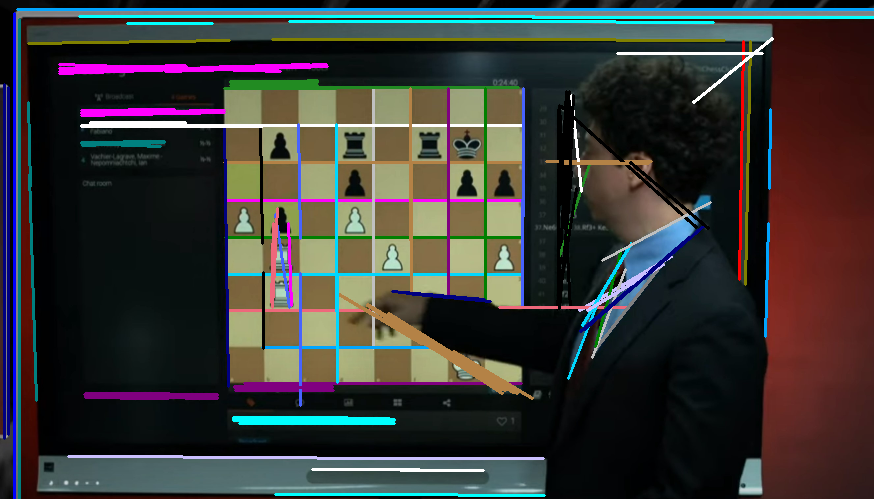

[0, 1, 2, 3, 4, 2, 2, 7, 8, 9, 8, 11, 12, 4, 46, 15, 16, 17, 18, 19, 15, 21, 22, 23, 24, 2, 26, 27, 28, 29, 4, 2, 32, 33, 34, 21, 36, 27, 38, 17, 27, 41, 42, 12, 42, 45, 46, 15, 17, 49, 53, 46, 52, 53, 54, 55, 38, 32, 27, 29, 22, 46, 46, 34, 42, 46, 46, 67, 42, 19, 70, 71, 54, 17, 67, 49, 76, 77, 78, 53, 27, 27, 53, 83, 78, 12, 33, 18, 88, 53, 78, 36, 92, 93, 94, 78, 96, 18, 53, 99, 42, 78, 49, 55, 53, 67, 46, 78, 108, 46, 67, 111, 112, 53, 17, 78, 12, 88, 27, 42, 53, 27, 17, 99, 93, 108, 78, 127]
defaultdict(<class 'list'>, {0: [array([ 14, 498,  14,  13], dtype=int32)], 1: [array([ 17,   9, 873,   9], dtype=int32)], 2: [array([289,  21, 615,  21], dtype=int32), array([532,  17, 873,  17], dtype=int32), array([ 79,  16, 534,  16], dtype=int32), array([127,  23, 212,  23], dtype=int32), array([616,  22, 713,  22], dtype=int32)], 3: [array([225, 237, 522, 237], dtype=int32)], 4: [array([272,  39, 615,  39], dtype=int32), array([616,  40, 724,  40], dtype=int32), array([ 28,  43, 229,  4

In [124]:
from collections import defaultdict
st= time.time()

for id in range(len(line_id)):
  make_set(id)

t2 = time.time()
for id1 in range(len(line_id)):
  for id2 in range(id1, len(line_id)):
    if similar(line_id[id1], line_id[id2]):  
      union_sets(id1, id2)
t3 = time.time()
print(t3-t2)

colors = [
    (255, 0, 0),    # Red
    (255, 165, 0),  # Orange
    (255, 255, 0),  # Yellow
    (0, 128, 0),    # Green
    (0, 128, 128),  # Teal
    (0, 0, 255),    # Blue
    (128, 0, 128),  # Purple
    (255, 0, 255),  # Magenta
    (128, 0, 0),    # Maroon
    (128, 128, 0),  # Olive
    (128, 128, 128),# Grey
    (192, 192, 192),# Silver
    (255, 255, 255),# White
    (0, 0, 0),      # Black
    (255, 99, 71),  # Tomato
    (255, 192, 203),# Pink
    (255, 215, 0),  # Gold
    (34, 139, 34),  # Forest green
    (70, 130, 180), # Steel blue
    (123, 104, 238) # Medium purple
]

line_image2 = np.copy(img)

groups = defaultdict(list)
for id in range(len(line_id)):
  group_id = find_set(id)
  c = colors[group_id%len(colors)]
  line = line_id[id]
  groups[group_id].append(line)
  x1, y1, x2, y2 = line
  cv2.line(line_image2,(x1,y1),(x2,y2),c,2)

cv2_imshow(line_image2)

print(parent)
print(groups)

In [114]:
t4 = time.time()
print(similar([0,0,1,1], [2.2,2.3,3,3]))
t5 = time.time()
print(t5-t4)

True
0.00035262107849121094


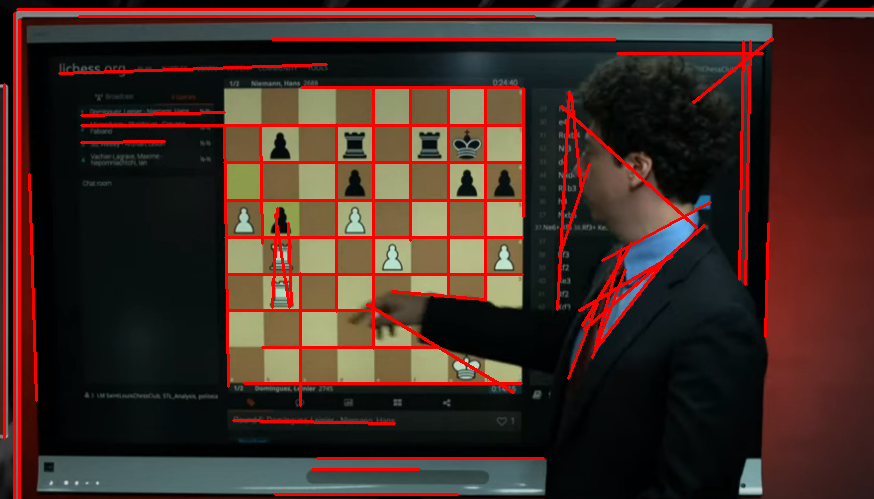

In [131]:
line_image3 = np.copy(img)

for group_id in groups:
  group = groups[group_id]
  max_len = 0
  max_idx = 0
  for i,line in enumerate(group):
    length = (line[3]-line[1])**2 + (line[2]-line[0])**2
    if length > max_len:
      max_len = length
      max_idx = i
  line = group[max_idx]
  cv2.line(line_image3,(line[0],line[1]),(line[2],line[3]),(0,0,255),2)
  
cv2_imshow(line_image3)